# Assignment 3x: CNNs for Brain MRIs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

import os
import glob
import time
from tqdm import tqdm  # i like to see progress :)

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# only run once if we don't have the data
# import opendatasets as od

# # to download the dataset from kaggle
# # od.download("https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation")

### UNet Model Implementations

In [ ]:
# Architecture inspired by https://arxiv.org/abs/1505.04597
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d1 = self.up1(b)
        d1 = torch.cat((e4, d1), dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat((e3, d2), dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.dec3(d3)

        d4 = self.up4(d3)
        d4 = torch.cat((e1, d4), dim=1)
        d4 = self.dec4(d4)

        return self.final_conv(d4)

In [ ]:
# Architecture inspired by https://arxiv.org/html/2309.13553
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Flatten the tensors
        inputs = torch.sigmoid(logits).view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.0 * intersection + self.smooth) / (
            inputs.sum() + targets.sum() + self.smooth
        )

        return 1 - dice

In [ ]:
# Architecture inspired by https://arxiv.org/abs/1802.06955
class RecurrentConvLayer(nn.Module):
    def __init__(self, out_channels, t=2):
        super().__init__()
        self.t = t
        self.out_channels = out_channels
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        prev_state = x

        for _ in range(self.t):
            curr_state = self.conv(prev_state)
            curr_state = self.bn(curr_state)

            curr_state = curr_state + x
            prev_state = self.relu(curr_state)

        return prev_state


class RRCU_Block(nn.Module):
    def __init__(self, in_channels, out_channels, t=2):
        super().__init__()
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        self.ro = RecurrentConvLayer(out_channels, t=t)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(
                in_channels, out_channels, kernel_size=1, stride=1
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        path_a = self.conv1x1(x)
        path_a = self.ro(path_a)

        path_b = self.shortcut(x)

        return path_a + path_b


class R2UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, t=2):
        super().__init__()

        self.enc1 = RRCU_Block(in_channels, 64, t=t)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc2 = RRCU_Block(64, 128, t=t)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc3 = RRCU_Block(128, 256, t=t)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.enc4 = RRCU_Block(256, 512, t=t)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.bottleneck = RRCU_Block(512, 1024, t=t)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = RRCU_Block(1024, 512, t=t)  # 1024 because 512(up) + 512(enc4)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = RRCU_Block(512, 256, t=t)  # 512 because 256(up) + 256(enc3)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = RRCU_Block(256, 128, t=t)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = RRCU_Block(128, 64, t=t)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        b = self.bottleneck(p4)

        d1 = self.up1(b)
        d1 = torch.cat((e4, d1), dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat((e3, d2), dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.dec3(d3)

        d4 = self.up4(d3)
        d4 = torch.cat((e1, d4), dim=1)
        d4 = self.dec4(d4)

        return self.final_conv(d4)

## Training & Plotting Architecture

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def _make_optimizer(model, name="sgd", lr=0.05):
    name = name.lower()
    if name == "sgd":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if name == "adam":
        return optim.Adam(model.parameters(), lr=lr)
    raise ValueError(f"Unknown optimizer: {name}")


@torch.no_grad()
def evaluate_segmentation(model, loader, device="cpu", criterion=None):
    model.eval()
    total_pixels, correct_pixels, total_loss = 0, 0, 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)

        if criterion is not None:
            total_loss += criterion(logits, y).item() * x.size(0)

        preds = torch.sigmoid(logits)
        # Threshold at 0.5 to get binary mask (0 or 1)
        pred_mask = (preds > 0.5).float()

        correct_pixels += (pred_mask == y).sum().item()
        total_pixels += torch.numel(y)

    avg_loss = (total_loss / len(loader.dataset)) if criterion is not None else None
    acc = correct_pixels / total_pixels
    return avg_loss, acc


def train_segmentation_model(
    model,
    train_loader,
    test_loader,
    epochs=15,
    optimizer_name="adam",
    lr=1e-4,
    device=None,
    criterion=None,
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if criterion is None:
        criterion = nn.BCEWithLogitsLoss()

    optimizer = _make_optimizer(model, name=optimizer_name, lr=lr)

    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    total_params = count_parameters(model)

    print(f"\nStarting training on device: {device.upper()}")
    start_time = time.time()

    train_loss, train_acc = 0.0, 0.0
    test_loss, test_acc = 0.0, 0.0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, correct, total_pixels = 0, 0, 0

        loop = tqdm(
            enumerate(train_loader, 1),
            total=len(train_loader),
            desc=f"Epoch {epoch}/{epochs}",
            leave=True,
        )

        for step, (x, y) in loop:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)

            probs = torch.sigmoid(logits)
            batch_acc = ((probs > 0.5) == y).float().mean().item()
            correct += ((probs > 0.5) == y).sum().item()
            total_pixels += torch.numel(y)

            loop.set_postfix(loss=loss.item(), acc=batch_acc)

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = correct / (total_pixels + 1e-8)

        test_loss, test_acc = evaluate_segmentation(
            model, test_loader, device, criterion
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

    total_time = time.time() - start_time

    print("\n" + "=" * 30)
    print("FINAL RESULT SUMMARY")
    print("=" * 30)
    print(f"Train Loss:     {train_loss:.4f}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Training Time:  {total_time:.2f}s")
    print(f"Params:         {total_params:,}")
    print("=" * 30 + "\n")

    return model, history

In [7]:
def plot_history(history, title="Training History"):
    """
    Plots train/test loss and accuracy curves from a history dictionary:
    history = {
        'train_loss': [...],
        'train_acc':  [...],
        'test_loss':  [...],
        'test_acc':   [...]
    }
    """
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_loss"], "o-", label="Train Loss")
    plt.plot(epochs, history["test_loss"], "s-", label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(epochs)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_acc"], "o-", label="Train Accuracy")
    plt.plot(epochs, history["test_acc"], "s-", label="Test Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(epochs)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

## Loading MRI Dataset

In [ ]:
# This loader code was inspired from various notebooks on the Kaggle dataset page
# citation: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation


class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_transform=None):
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_paths = []
        self.mask_paths = []

        all_files = glob.glob(os.path.join(root_dir, "**/*.tif"), recursive=True)

        for file_path in all_files:
            if "_mask" not in file_path:
                self.image_paths.append(file_path)
                self.mask_paths.append(file_path.replace(".tif", "_mask.tif"))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


mri_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

mask_transform = transforms.Compose(
    [transforms.Resize((256, 256)), transforms.ToTensor()]
)

DATA_DIR = "./data/lgg-mri-segmentation/kaggle_3m/"

full_dataset = MRIDataset(
    root_dir=DATA_DIR, transform=mri_transform, mask_transform=mask_transform
)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

mri_train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True
)

mri_test_loader = DataLoader(
    test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True
)

print(
    "MRI data loaded:",
    f"\n  Training samples: {len(train_dataset)}",
    f"\n  Test samples: {len(test_dataset)}",
    f"\n  Batch size: {mri_train_loader.batch_size}",
)

MRI data loaded: 
  Training samples: 3143 
  Test samples: 786 
  Batch size: 8


## Model Testing


Starting training on device: CUDA


Epoch 5/5: 100%|██████████| 393/393 [00:29<00:00, 13.14it/s, acc=0.992, loss=0.0301] 



FINAL RESULT SUMMARY
Train Loss:     0.0277
Train Accuracy: 0.9924
Test Loss:      0.0258
Test Accuracy:  0.9933
Training Time:  202.56s
Params:         31,043,521



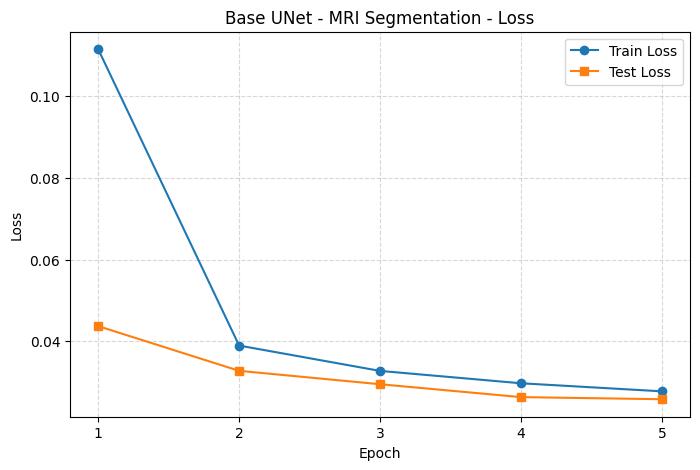

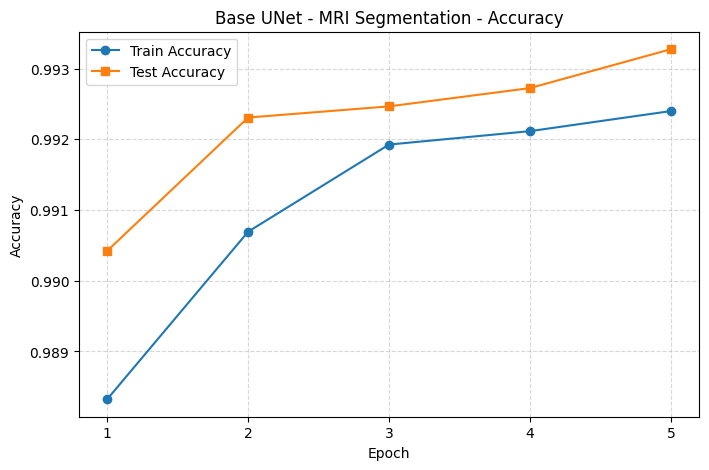

In [9]:
base_unet_config = {
    "learning_rate": 0.001,
    "epochs": 5,
    "optimizer": "sgd",
    "batch_size": 32,
}
base_unet_model = UNet(in_channels=3, out_channels=1)
base_trained_model, base_model_history = train_segmentation_model(
    base_unet_model,
    mri_train_loader,
    mri_test_loader,
    epochs=base_unet_config["epochs"],
    optimizer_name=base_unet_config["optimizer"],
    lr=base_unet_config["learning_rate"],
)

plot_history(base_model_history, title="Base UNet - MRI Segmentation")


Starting training on device: CUDA


Epoch 1/10:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 10/10: 100%|██████████| 393/393 [00:29<00:00, 13.45it/s, acc=0.993, loss=0.0183] 



FINAL RESULT SUMMARY
Train Loss:     0.0112
Train Accuracy: 0.9959
Test Loss:      0.0098
Test Accuracy:  0.9966
Training Time:  324.00s
Params:         31,043,521



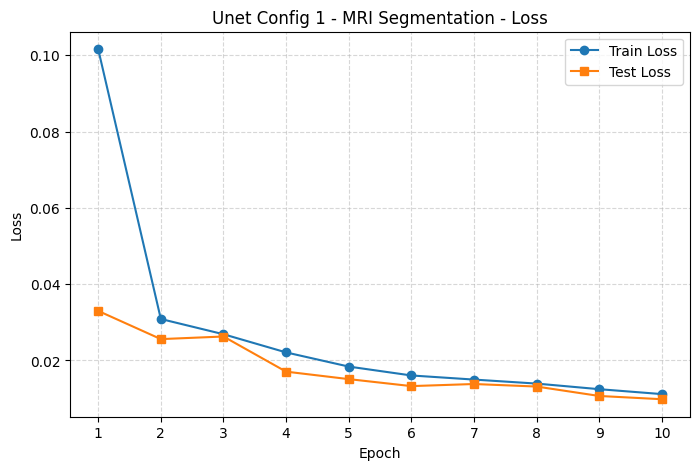

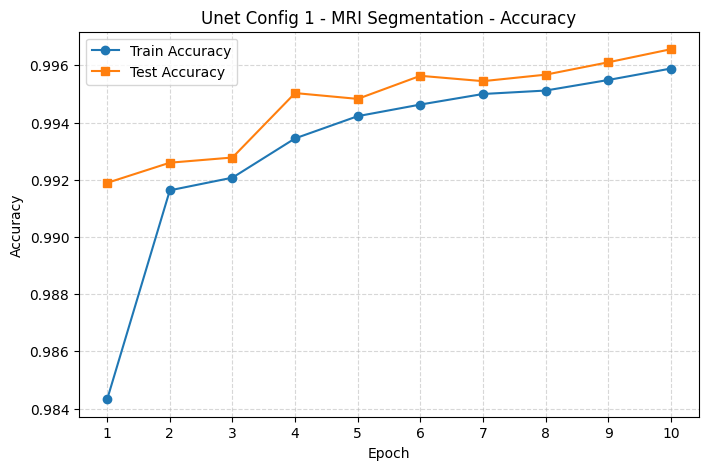

In [11]:
new_unet_config_1 = {
    "learning_rate": 0.001,
    "epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
}
new_unet_model_1 = UNet(in_channels=3, out_channels=1)
new_trained_model_1, new_model_history_1 = train_segmentation_model(
    new_unet_model_1,
    mri_train_loader,
    mri_test_loader,
    epochs=new_unet_config_1["epochs"],
    optimizer_name=new_unet_config_1["optimizer"],
    lr=new_unet_config_1["learning_rate"],
)

plot_history(new_model_history_1, title="Unet Config 1 - MRI Segmentation")


Starting training on device: CUDA


Epoch 5/5: 100%|██████████| 393/393 [00:29<00:00, 13.15it/s, acc=0.994, loss=0.0386]



FINAL RESULT SUMMARY
Train Loss:     0.0458
Train Accuracy: 0.9943
Test Loss:      0.0372
Test Accuracy:  0.9956
Training Time:  160.77s
Params:         31,043,521



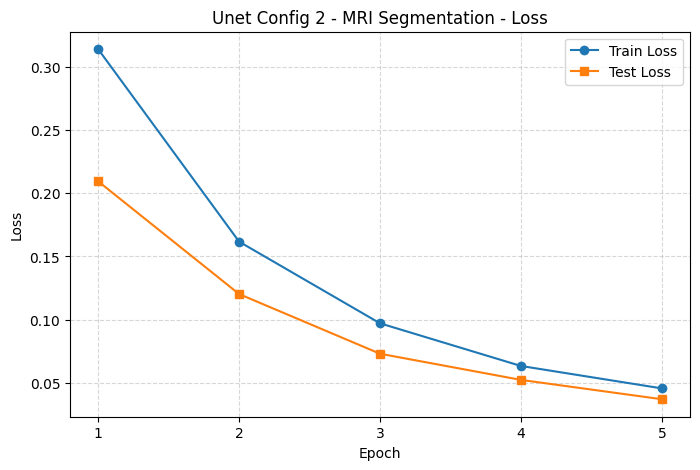

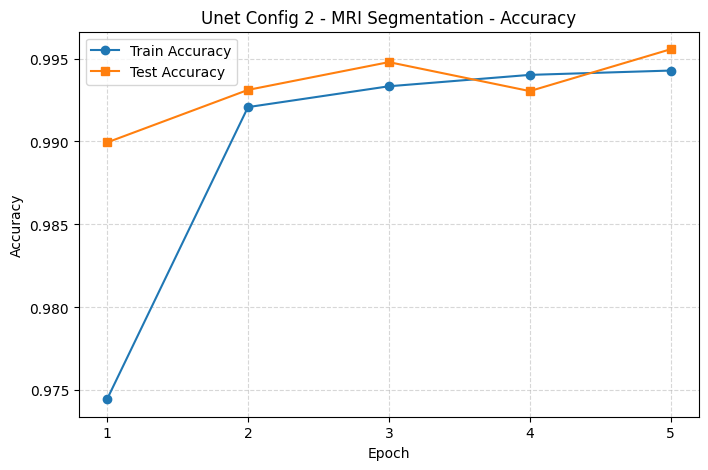

In [12]:
new_unet_config_2 = {
    "learning_rate": 0.0001,
    "epochs": 5,
    "optimizer": "adam",
    "batch_size": 32,
}
new_unet_model_2 = UNet(in_channels=3, out_channels=1)
new_trained_model_2, new_model_history_2 = train_segmentation_model(
    new_unet_model_2,
    mri_train_loader,
    mri_test_loader,
    epochs=new_unet_config_2["epochs"],
    optimizer_name=new_unet_config_2["optimizer"],
    lr=new_unet_config_2["learning_rate"],
)

plot_history(new_model_history_2, title="Unet Config 2 - MRI Segmentation")


Starting training on device: CUDA


Epoch 5/5: 100%|██████████| 393/393 [00:28<00:00, 13.87it/s, acc=0.998, loss=0.169] 



FINAL RESULT SUMMARY
Train Loss:     0.3879
Train Accuracy: 0.9934
Test Loss:      0.3635
Test Accuracy:  0.9947
Training Time:  154.99s
Params:         31,043,521



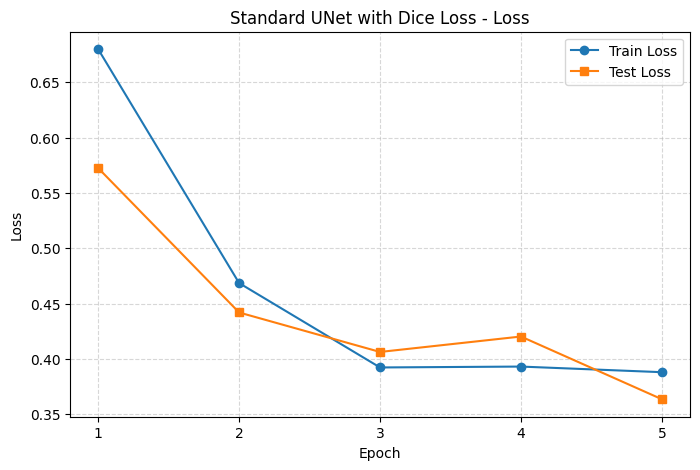

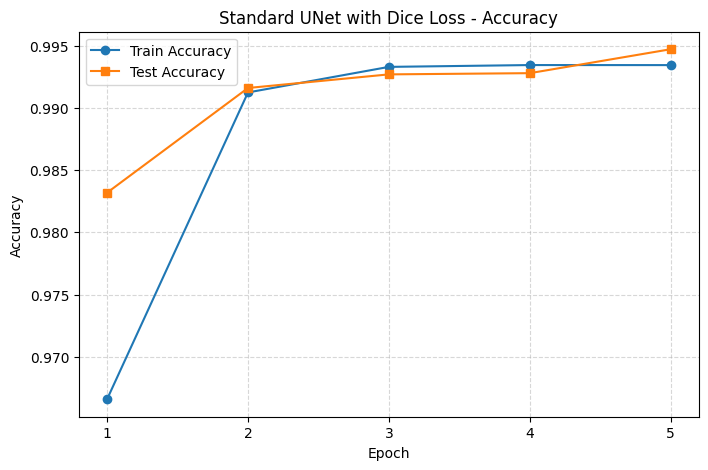

In [13]:
dice_config = {
    "learning_rate": 0.001,
    "epochs": 5,
    "optimizer": "adam",
    "batch_size": 16,
}
dice_unet_model = UNet(in_channels=3, out_channels=1)

dice_trained_model, dice_history = train_segmentation_model(
    dice_unet_model,
    mri_train_loader,
    mri_test_loader,
    epochs=dice_config["epochs"],
    optimizer_name=dice_config["optimizer"],
    lr=dice_config["learning_rate"],
    criterion=DiceLoss(),
)

plot_history(dice_history, title="Standard UNet with Dice Loss")


Starting training on device: CUDA


Epoch 5/5: 100%|██████████| 393/393 [00:37<00:00, 10.46it/s, acc=0.998, loss=0.0134] 



FINAL RESULT SUMMARY
Train Loss:     0.0333
Train Accuracy: 0.9913
Test Loss:      0.0336
Test Accuracy:  0.9911
Training Time:  202.65s
Params:         21,296,641



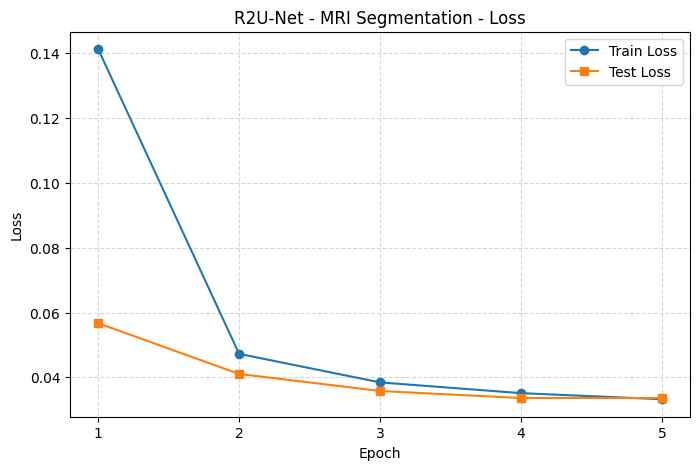

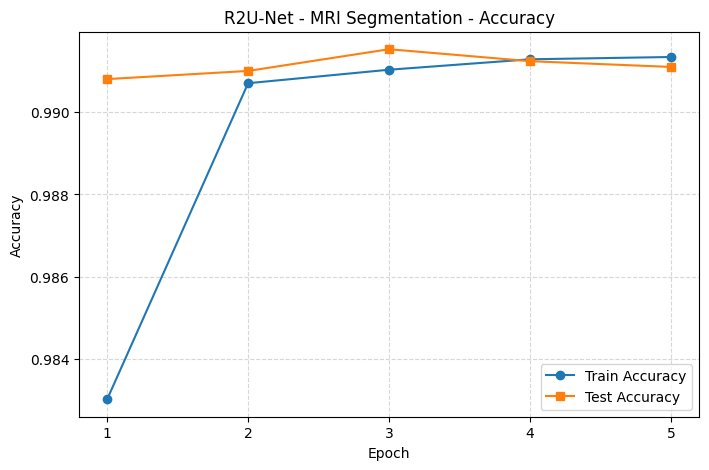

In [14]:
base_r2unet_config = {
    "learning_rate": 1e-4,
    "epochs": 5,
    "optimizer": "sgd",
    "batch_size": 16,
}
base_r2unet_model = R2UNet(in_channels=3, out_channels=1, t=2)
base_r2unet_trained_model, base_r2unet_model_history = train_segmentation_model(
    base_r2unet_model,
    mri_train_loader,
    mri_test_loader,
    epochs=base_r2unet_config["epochs"],
    optimizer_name=base_r2unet_config["optimizer"],
    lr=base_r2unet_config["learning_rate"],
)

plot_history(base_r2unet_model_history, title="R2U-Net - MRI Segmentation")


Starting training on device: CUDA


Epoch 5/5: 100%|██████████| 393/393 [00:35<00:00, 11.02it/s, acc=1, loss=0.00144]    



FINAL RESULT SUMMARY
Train Loss:     0.0095
Train Accuracy: 0.9965
Test Loss:      0.0089
Test Accuracy:  0.9968
Training Time:  201.57s
Params:         21,296,641



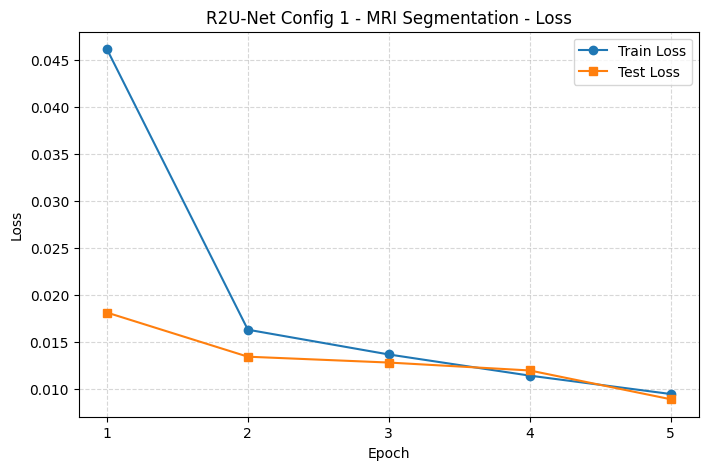

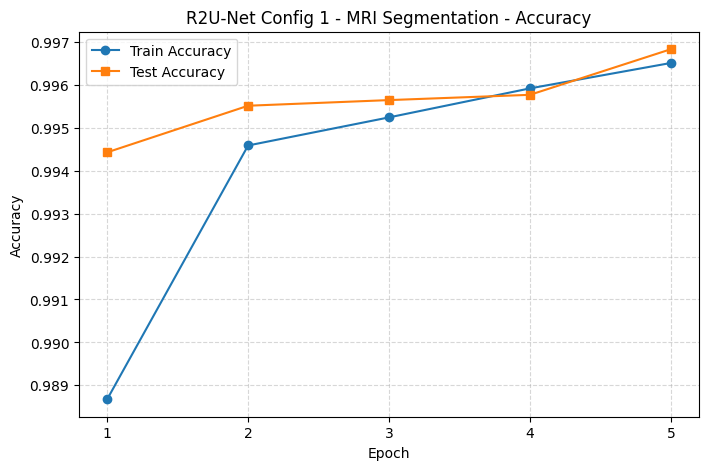

In [15]:
r2unet_config_1 = {
    "learning_rate": 1e-4,
    "epochs": 5,
    "optimizer": "adam",
    "batch_size": 16,
}
r2unet_model_1 = R2UNet(in_channels=3, out_channels=1, t=2)
r2unet_trained_model_1, r2unet_model_history_1 = train_segmentation_model(
    r2unet_model_1,
    mri_train_loader,
    mri_test_loader,
    epochs=r2unet_config_1["epochs"],
    optimizer_name=r2unet_config_1["optimizer"],
    lr=r2unet_config_1["learning_rate"],
)

plot_history(r2unet_model_history_1, title="R2U-Net Config 1 - MRI Segmentation")